## Practice

c:\Users\joshu\Desktop\uni\thesis_UCL\RCGP_experiments\tf-env\Lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


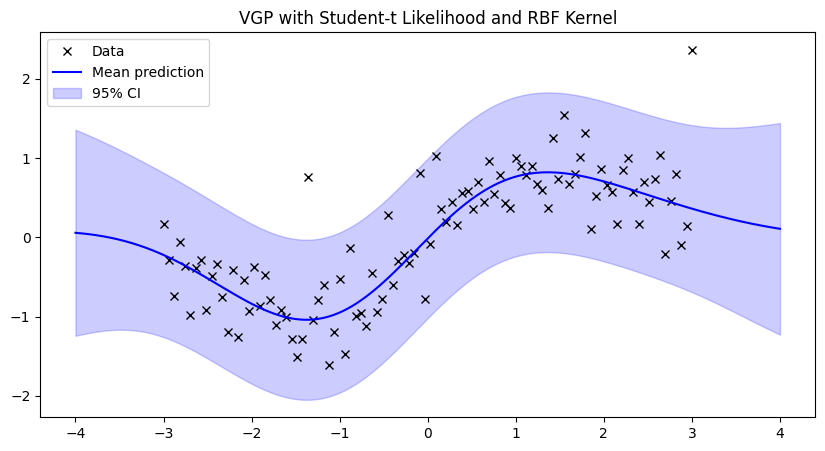

In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Generate synthetic dataset
X = np.linspace(-3, 3, 100).reshape(-1, 1)
Y = np.sin(X) + 0.3 * np.random.standard_t(df=3, size=X.shape)  # Heavy-tailed noise

X = X.astype(np.float64)
Y = Y.astype(np.float64)

# Step 2: Define the RBF kernel
kernel = gpflow.kernels.SquaredExponential()

# Step 3: Define the Student-t likelihood
likelihood = gpflow.likelihoods.StudentT(df=3.0)

# Step 4: Create the VGP model
model = gpflow.models.VGP(
    data=(X, Y),
    kernel=kernel,
    likelihood=likelihood
)

# Step 5: Train the model using a Scipy optimizer
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return -model.maximum_log_likelihood_objective()

opt.minimize(objective_closure, model.trainable_variables, options=dict(maxiter=1000))

# Step 6: Make predictions
Xtest = np.linspace(-4, 4, 200).reshape(-1, 1)
mean, var = model.predict_y(Xtest)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(X, Y, 'kx', label='Data')
plt.plot(Xtest, mean, 'b', label='Mean prediction')
plt.fill_between(Xtest[:, 0],
                 mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
                 mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
                 color='blue', alpha=0.2, label='95% CI')
plt.title("VGP with Student-t Likelihood and RBF Kernel")
plt.legend()
plt.show()


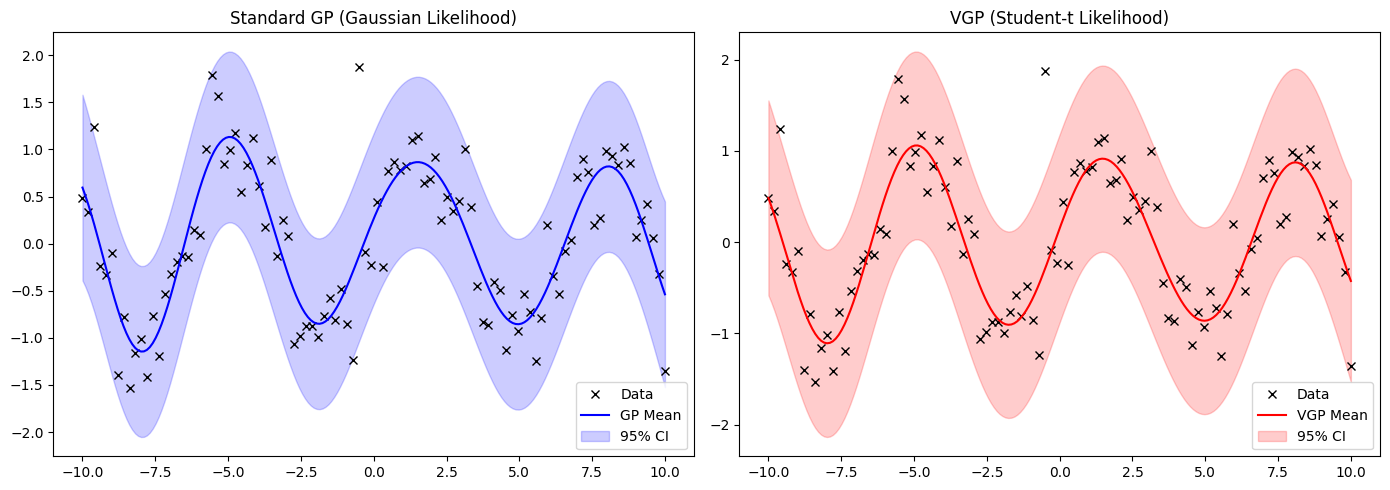

In [2]:
import gpflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Generate synthetic dataset with heavy-tailed noise
X = np.linspace(-10, 10, 100).reshape(-1, 1)
Y = np.sin(X) + 0.3 * np.random.standard_t(df=3, size=X.shape)  # Heavy-tailed noise

X = X.astype(np.float64)
Y = Y.astype(np.float64)

# Step 2: Define test points
Xtest = np.linspace(-10, 10, 200).reshape(-1, 1)

# ================================
# GP Model (standard regression)
# ================================
kernel_gp = gpflow.kernels.SquaredExponential()
model_gp = gpflow.models.GPR(
    data=(X, Y),
    kernel=kernel_gp,
    mean_function=None
)

# Optimize
opt = gpflow.optimizers.Scipy()
opt.minimize(
    model_gp.training_loss,
    model_gp.trainable_variables,
    options=dict(maxiter=1000)
)

# Predictions
mean_gp, var_gp = model_gp.predict_y(Xtest)

# ================================
# VGP Model with Student-t likelihood
# ================================
kernel_vgp = gpflow.kernels.SquaredExponential()
likelihood_vgp = gpflow.likelihoods.StudentT()
model_vgp = gpflow.models.VGP(
    data=(X, Y),
    kernel=kernel_vgp,
    likelihood=likelihood_vgp
)

# Optimize
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))

# Predictions
mean_vgp, var_vgp = model_vgp.predict_y(Xtest)

# ================================
# Plot the results
# ================================
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# GP with Gaussian Likelihood
axs[0].plot(X, Y, 'kx', label='Data')
axs[0].plot(Xtest, mean_gp, 'b', label='GP Mean')
axs[0].fill_between(
    Xtest[:, 0],
    mean_gp[:, 0] - 1.96 * np.sqrt(var_gp[:, 0]),
    mean_gp[:, 0] + 1.96 * np.sqrt(var_gp[:, 0]),
    color='blue', alpha=0.2, label='95% CI'
)
axs[0].set_title("Standard GP (Gaussian Likelihood)")
axs[0].legend()

# VGP with Student-t Likelihood
axs[1].plot(X, Y, 'kx', label='Data')
axs[1].plot(Xtest, mean_vgp, 'r', label='VGP Mean')
axs[1].fill_between(
    Xtest[:, 0],
    mean_vgp[:, 0] - 1.96 * np.sqrt(var_vgp[:, 0]),
    mean_vgp[:, 0] + 1.96 * np.sqrt(var_vgp[:, 0]),
    color='red', alpha=0.2, label='95% CI'
)
axs[1].set_title("VGP (Student-t Likelihood)")
axs[1].legend()

plt.tight_layout()
plt.show()

## t-MOGP

In [ ]:
import numpy as np

X_base = np.linspace(0, 10, 50).reshape(-1, 1)
X = np.vstack([X_base, X_base])  # shape (100, 1)

task_indices = np.array([0]*50 + [1]*50).reshape(-1, 1)
X_multi = np.hstack([X, task_indices])

Y_task_0 = np.sin(X_base) + 0.1 * np.random.randn(50, 1)
Y_task_1 = np.cos(X_base) + 0.1 * np.random.randn(50, 1)
Y_multi = np.vstack([Y_task_0, Y_task_1])  # shape (100, 1)

# Base kernel on input (X[:, 0])
k1 = gpflow.kernels.SquaredExponential(active_dims=[0])
k1.variance.assign(1.0)
gpflow.utilities.set_trainable(k1.variance, False)

# Coregion kernel on task index (X[:, 1])
k2 = gpflow.kernels.Coregion(output_dim=2, rank=1, active_dims=[1])
k2.kappa.assign([1e-6, 1e-6])
gpflow.utilities.set_trainable(k2.kappa, False)

# Multiply kernels
kernel = k1 * k2

likelihood_vgp = gpflow.likelihoods.StudentT()
model = gpflow.models.VGP(
    data=(X, Y),
    kernel=kernel,
    likelihood=likelihood_vgp
)

def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))

In [ ]:
from gpflow.models import GPR
import tensorflow as tf

likelihood_vgp = gpflow.likelihoods.StudentT()

model = gpflow.models.VGP(
    data=(X, Y),
    kernel=kernel,
    likelihood=likelihood_vgp
)
# model.likelihood.variance.assign(1e-4)  # Optional: fix noise

# Optimize
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))


import matplotlib.pyplot as plt

# Number of tasks
num_tasks = 2

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

plt.figure(figsize=(10, 5))

for task in range(num_tasks):
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx][:, 0]
    Y_train_task = Y_multi[idx][:, 0]

    mean, var = model.predict_y(X_test.flatten())
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)

    # Plot
    plt.subplot(1, num_tasks, task + 1)
    plt.title(f"Task {task}")
    plt.plot(X_test, mean, 'C0', label='Predictive mean')
    plt.fill_between(X_test[:, 0], lower[:, 0], upper[:, 0], color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

plt.tight_layout()
plt.show()


ShapeMismatchError: 
Tensor shape mismatch.
  Function: GPModel.predict_y
    Declared: c:\Users\joshu\Desktop\uni\thesis_UCL\RCGP_experiments\tf-env\Lib\site-packages\gpflow\models\model.py:282
    Argument: Xnew
      Expected: [batch..., N, D]
      Actual:   [200]


<Figure size 1000x500 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt

# Number of tasks
num_tasks = 2

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

plt.figure(figsize=(10, 5))

for task in range(num_tasks):
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx][:, 0]
    Y_train_task = Y_multi[idx][:, 0]

    mean, var = model.predict_y(X_test.flatten())
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)

    # Plot
    plt.subplot(1, num_tasks, task + 1)
    plt.title(f"Task {task}")
    plt.plot(X_test, mean, 'C0', label='Predictive mean')
    plt.fill_between(X_test[:, 0], lower[:, 0], upper[:, 0], color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

plt.tight_layout()
plt.show()

ShapeMismatchError: 
Tensor shape mismatch.
  Function: GPModel.predict_y
    Declared: c:\Users\joshu\Desktop\uni\thesis_UCL\RCGP_experiments\tf-env\Lib\site-packages\gpflow\models\model.py:282
    Argument: Xnew
      Expected: [batch..., N, D]
      Actual:   [200]


<Figure size 1000x500 with 0 Axes>

In [ ]:
print("X_test shape:", X_test.shape)
print("task_col shape:", task_col.shape)
print("X_test_task shape:", X_test_task.shape)
print("Model input dimension expected:", model.input_shape)

X_test shape: (200, 1)
task_col shape: (200, 1)
X_test_task shape: (200, 2)


AttributeError: 'VGP' object has no attribute 'input_shape'

In [23]:
print("Kernel parameters:")
for param in model.kernel.trainable_parameters:
    print(f"{param.name}: {param.numpy()}")

print("\nLikelihood parameters:")
for param in model.likelihood.trainable_parameters:
    print(f"{param.name}: {param.numpy()}")


Kernel parameters:
softplus: 0.9999999999999999
identity: [[0.1]
 [0.1]]

Likelihood parameters:
chain_of_shift_of_softplus: 1.0


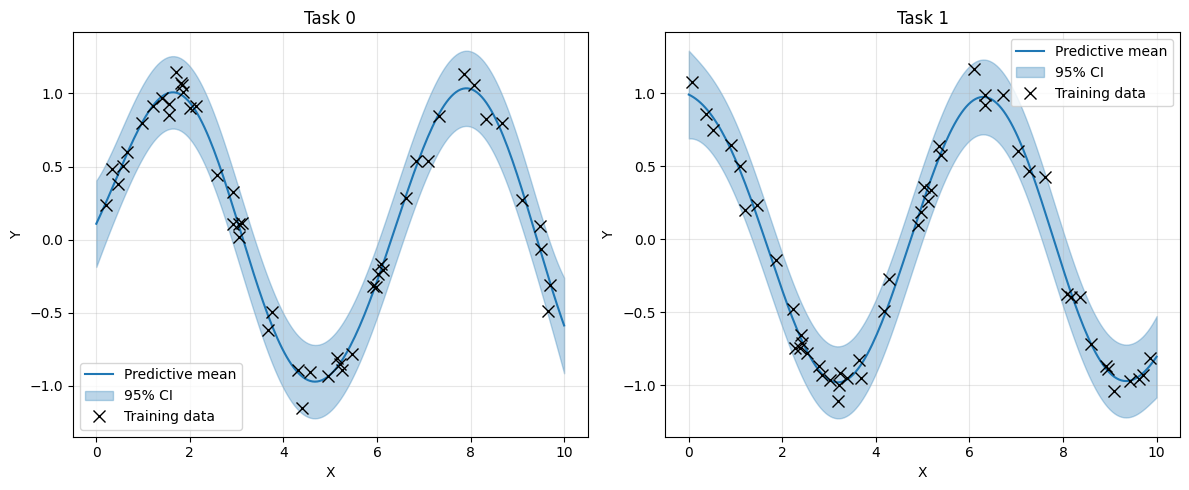


Alternative approach: Separate models per task


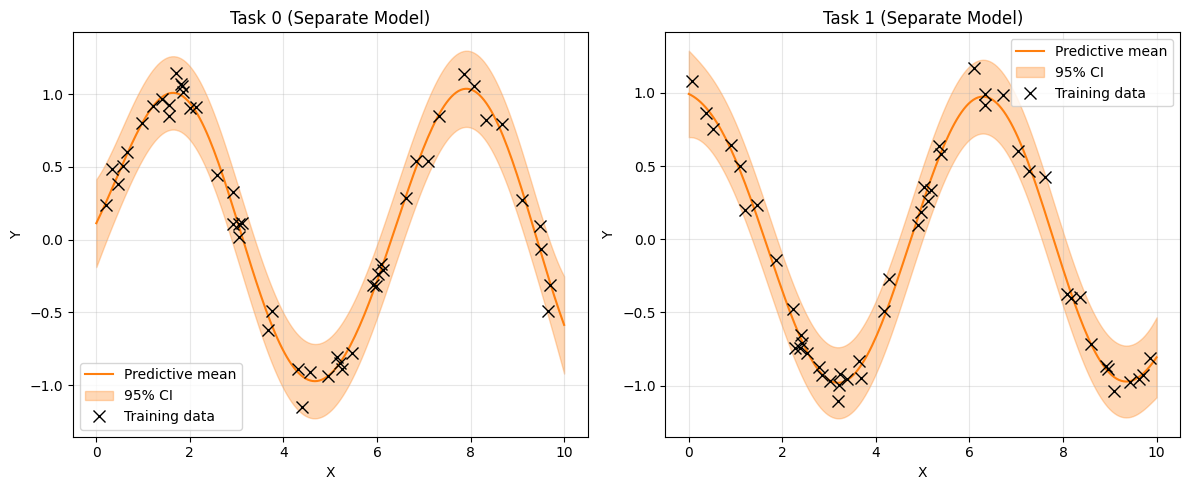

In [6]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gpflow.optimizers import Scipy

# Assuming you have your data defined somewhere
# X_multi should be shape (n_points, 2) where second column is task index
# Y_multi should be shape (n_points, 1)

# Example data generation (replace with your actual data)
np.random.seed(42)
n_points_per_task = 50
num_tasks = 2

# Generate example multi-task data
X_multi = []
Y_multi = []

for task in range(num_tasks):
    X_task = np.random.uniform(0, 10, n_points_per_task).reshape(-1, 1)
    # Different functions for different tasks
    if task == 0:
        Y_task = np.sin(X_task) + 0.1 * np.random.randn(n_points_per_task, 1)
    else:
        Y_task = np.cos(X_task) + 0.1 * np.random.randn(n_points_per_task, 1)
    
    # Add task index as second column
    X_task_with_index = np.hstack([X_task, np.full((n_points_per_task, 1), task)])
    
    X_multi.append(X_task_with_index)
    Y_multi.append(Y_task)

X_multi = np.vstack(X_multi)
Y_multi = np.vstack(Y_multi)

# Define kernel (assuming you want a multi-task kernel)
# For multi-task GP, you might want to use a kernel that handles task indices
base_kernel = gpflow.kernels.RBF(lengthscales=1.0, active_dims=[0])  # Only on input dimension
task_kernel = gpflow.kernels.RBF(lengthscales=1.0, active_dims=[1])  # Only on task dimension
kernel = base_kernel * task_kernel

# Or use a simpler approach with separate models per task
# Here's the corrected VGP model:

# Create the VGP model
likelihood_vgp = gpflow.likelihoods.StudentT()

model_vgp = gpflow.models.VGP(
    data=(X_multi, Y_multi),
    kernel=kernel,
    likelihood=likelihood_vgp
)

# Optional: fix noise variance
# model_vgp.likelihood.scale.assign(1e-4)

# Set up optimizer
opt = Scipy()

# Optimize - fixed variable names and objective function
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

# Run optimization
opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))

# Plotting
plt.figure(figsize=(12, 5))

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

for task in range(num_tasks):
    # Get training data for this task
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx, 0]
    Y_train_task = Y_multi[idx, 0]
    
    # Create test input with task index
    X_test_task = np.hstack([X_test, np.full((len(X_test), 1), task)])
    
    # Make predictions
    mean, var = model_vgp.predict_y(X_test_task)
    
    # Convert to numpy for plotting
    mean = mean.numpy()
    var = var.numpy()
    
    # Calculate confidence intervals
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)
    
    # Plot
    plt.subplot(1, num_tasks, task + 1)
    plt.title(f"Task {task}")
    plt.plot(X_test.flatten(), mean.flatten(), 'C0', label='Predictive mean')
    plt.fill_between(X_test.flatten(), lower.flatten(), upper.flatten(), 
                     color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', markersize=8, label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Alternative: Separate models per task (often simpler and more effective)
print("\nAlternative approach: Separate models per task")

models = {}
predictions = {}

for task in range(num_tasks):
    # Get data for this task
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx, 0:1]  # Keep as 2D array
    Y_train_task = Y_multi[idx]
    
    # Create separate model for each task
    kernel_task = gpflow.kernels.RBF(lengthscales=1.0)
    likelihood_task = gpflow.likelihoods.StudentT()
    
    model_task = gpflow.models.VGP(
        data=(X_train_task, Y_train_task),
        kernel=kernel_task,
        likelihood=likelihood_task
    )
    
    # Optimize
    def objective_closure_task():
        return -model_task.maximum_log_likelihood_objective()
    
    opt.minimize(objective_closure_task, model_task.trainable_variables, 
                options=dict(maxiter=1000))
    
    models[task] = model_task
    
    # Make predictions
    mean, var = model_task.predict_y(X_test)
    predictions[task] = (mean.numpy(), var.numpy())

# Plot separate models
plt.figure(figsize=(12, 5))

for task in range(num_tasks):
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx, 0]
    Y_train_task = Y_multi[idx, 0]
    
    mean, var = predictions[task]
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)
    
    plt.subplot(1, num_tasks, task + 1)
    plt.title(f"Task {task} (Separate Model)")
    plt.plot(X_test.flatten(), mean.flatten(), 'C1', label='Predictive mean')
    plt.fill_between(X_test.flatten(), lower.flatten(), upper.flatten(), 
                     color='C1', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', markersize=8, label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Optimizing ICM model...

Learned coregionalization parameters:
Coregionalization matrix B:
[[ 1.23131828 -0.08817101]
 [-0.08817101  1.0066763 ]]

Base kernel lengthscale: 1.8331339243591092
Base kernel variance: 0.8916099652988764


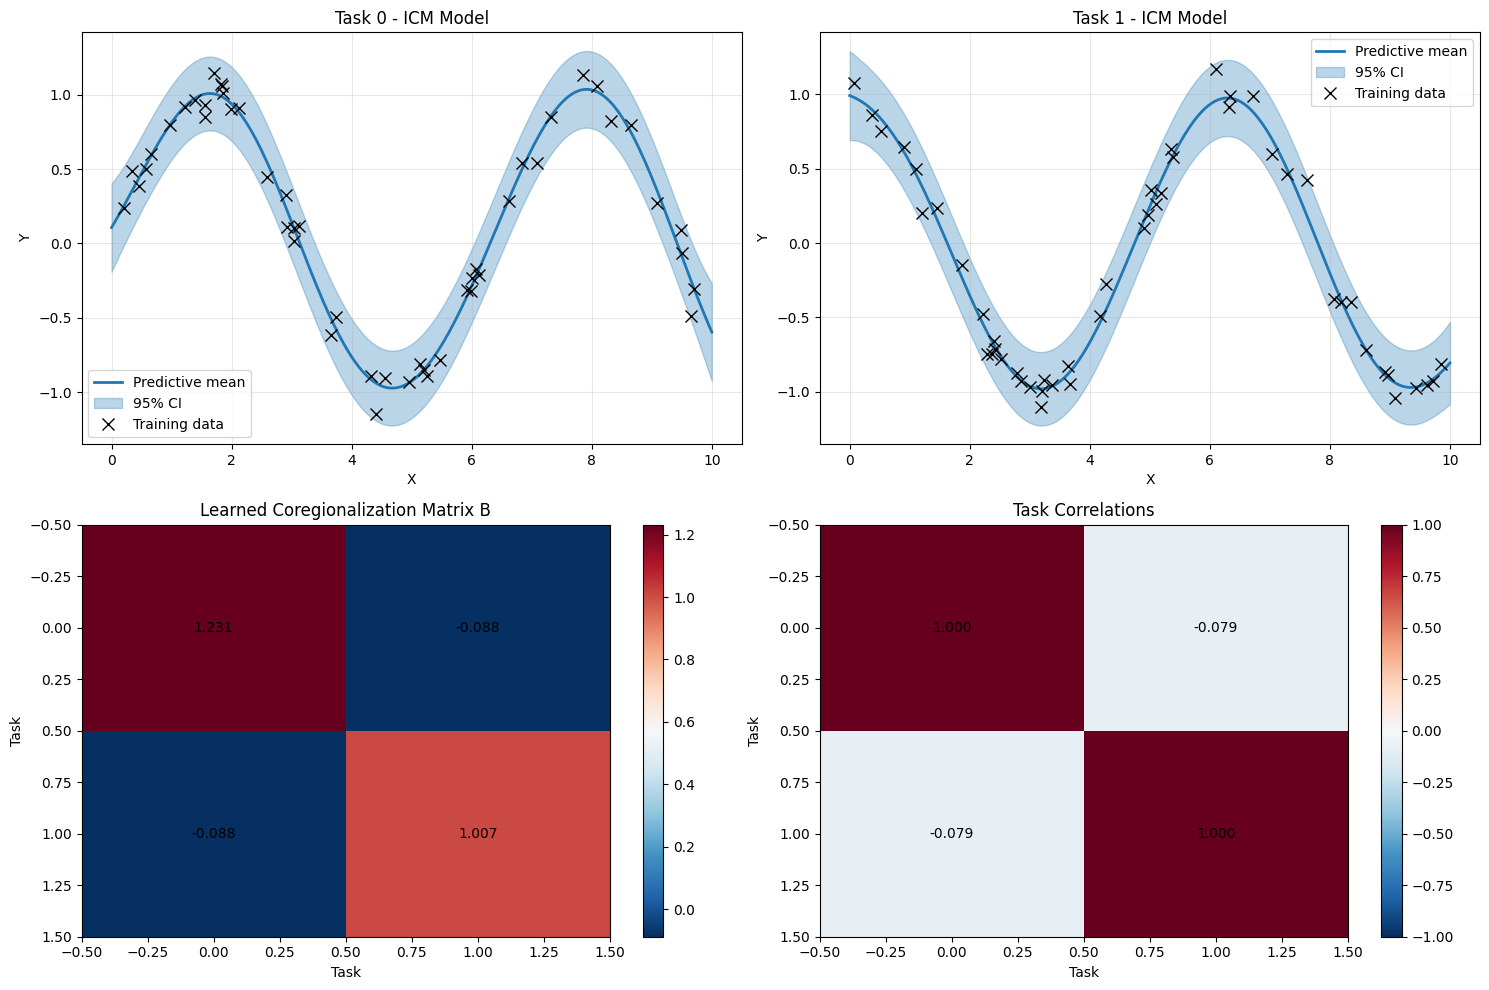


Task correlations:
Task 0 and Task 1 have weak correlation (ρ = -0.079)

TRANSFER LEARNING EXAMPLE
Simulating transfer learning scenario...
- Task 0: Many training points
- Task 1: Few training points
- ICM should help Task 1 learn from Task 0
Training transfer learning model...
Training independent models for comparison...


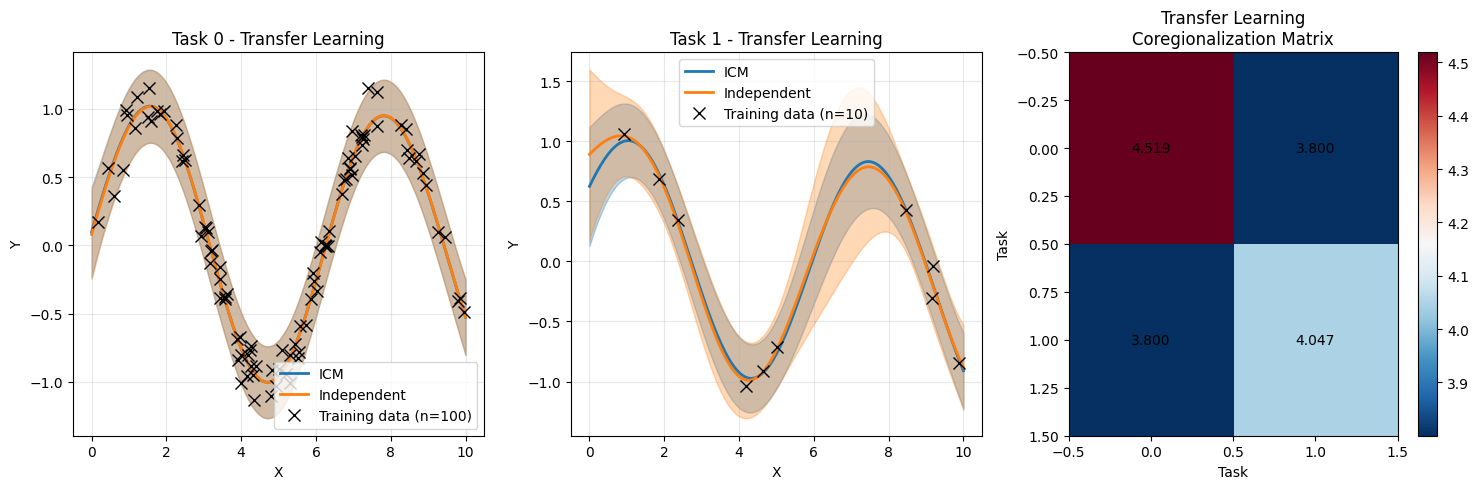


Transfer learning coregionalization matrix:
[[4.5190598  3.80024507]
 [3.80024507 4.04672366]]
Task correlation: 0.889
This shows how much Task 1 (few data) benefits from Task 0 (lots of data)


In [7]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gpflow.optimizers import Scipy

# Assuming you have your data defined somewhere
# X_multi should be shape (n_points, 2) where second column is task index
# Y_multi should be shape (n_points, 1)

# Example data generation (replace with your actual data)
np.random.seed(42)
n_points_per_task = 50
num_tasks = 2

# Generate example multi-task data
X_multi = []
Y_multi = []

for task in range(num_tasks):
    X_task = np.random.uniform(0, 10, n_points_per_task).reshape(-1, 1)
    # Different functions for different tasks
    if task == 0:
        Y_task = np.sin(X_task) + 0.1 * np.random.randn(n_points_per_task, 1)
    else:
        Y_task = np.cos(X_task) + 0.1 * np.random.randn(n_points_per_task, 1)
    
    # Add task index as second column
    X_task_with_index = np.hstack([X_task, np.full((n_points_per_task, 1), task)])
    
    X_multi.append(X_task_with_index)
    Y_multi.append(Y_task)

X_multi = np.vstack(X_multi)
Y_multi = np.vstack(Y_multi)

# Define Intrinsic Coregionalization Model (ICM) kernel
# This kernel allows for learning correlations between tasks

# Base kernel on input space (does not see task index)
base_kernel = gpflow.kernels.RBF(lengthscales=1.0, active_dims=[0])

# Coregionalization kernel on task space
# This learns a positive semi-definite matrix B that captures task correlations
coregion_kernel = gpflow.kernels.Coregion(
    output_dim=num_tasks,  # Number of tasks
    rank=num_tasks,        # Rank of coregionalization matrix (can be < num_tasks for low-rank approximation)
    active_dims=[1]        # Operates on task dimension (column 1)
)

# ICM kernel: base_kernel ⊗ coregion_kernel
kernel = base_kernel * coregion_kernel

# Or use a simpler approach with separate models per task
# Here's the corrected VGP model:

# Create the VGP model
likelihood_vgp = gpflow.likelihoods.StudentT()

model_vgp = gpflow.models.VGP(
    data=(X_multi, Y_multi),
    kernel=kernel,
    likelihood=likelihood_vgp
)

# Optional: fix noise variance
# model_vgp.likelihood.scale.assign(1e-4)

# Set up optimizer
opt = Scipy()

# Optimize - fixed variable names and objective function
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

# Run optimization
print("Optimizing ICM model...")
opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))

# Print learned coregionalization matrix
print("\nLearned coregionalization parameters:")
print(f"Coregionalization matrix B:")
B_matrix = model_vgp.kernel.kernels[1].output_covariance()
print(B_matrix.numpy())

print(f"\nBase kernel lengthscale: {model_vgp.kernel.kernels[0].lengthscales.numpy()}")
print(f"Base kernel variance: {model_vgp.kernel.kernels[0].variance.numpy()}")

# The coregionalization matrix shows how tasks are correlated
# Diagonal elements show task-specific variances
# Off-diagonal elements show inter-task correlations

# Plotting with improved visualization
plt.figure(figsize=(15, 10))

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

# Plot predictions for each task
for task in range(num_tasks):
    # Get training data for this task
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx, 0]
    Y_train_task = Y_multi[idx, 0]
    
    # Create test input with task index
    X_test_task = np.hstack([X_test, np.full((len(X_test), 1), task)])
    
    # Make predictions
    mean, var = model_vgp.predict_y(X_test_task)
    
    # Convert to numpy for plotting
    mean = mean.numpy()
    var = var.numpy()
    
    # Calculate confidence intervals
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)
    
    # Plot
    plt.subplot(2, num_tasks, task + 1)
    plt.title(f"Task {task} - ICM Model")
    plt.plot(X_test.flatten(), mean.flatten(), 'C0', linewidth=2, label='Predictive mean')
    plt.fill_between(X_test.flatten(), lower.flatten(), upper.flatten(), 
                     color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', markersize=8, label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot coregionalization matrix as heatmap
plt.subplot(2, 2, 3)
B_matrix = model_vgp.kernel.kernels[1].output_covariance().numpy()
im = plt.imshow(B_matrix, cmap='RdBu_r', aspect='auto')
plt.colorbar(im)
plt.title('Learned Coregionalization Matrix B')
plt.xlabel('Task')
plt.ylabel('Task')
for i in range(num_tasks):
    for j in range(num_tasks):
        plt.text(j, i, f'{B_matrix[i,j]:.3f}', ha='center', va='center')

# Plot cross-correlations
plt.subplot(2, 2, 4)
correlations = np.zeros((num_tasks, num_tasks))
for i in range(num_tasks):
    for j in range(num_tasks):
        correlations[i, j] = B_matrix[i, j] / np.sqrt(B_matrix[i, i] * B_matrix[j, j])

im = plt.imshow(correlations, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(im)
plt.title('Task Correlations')
plt.xlabel('Task')
plt.ylabel('Task')
for i in range(num_tasks):
    for j in range(num_tasks):
        plt.text(j, i, f'{correlations[i,j]:.3f}', ha='center', va='center')

plt.tight_layout()
plt.show()

# Additional analysis: show how information is shared between tasks
print(f"\nTask correlations:")
for i in range(num_tasks):
    for j in range(i+1, num_tasks):
        corr = correlations[i, j]
        if corr > 0.1:
            print(f"Task {i} and Task {j} are positively correlated (ρ = {corr:.3f})")
        elif corr < -0.1:
            print(f"Task {i} and Task {j} are negatively correlated (ρ = {corr:.3f})")
        else:
            print(f"Task {i} and Task {j} have weak correlation (ρ = {corr:.3f})")


# Example of using the ICM model for transfer learning
print("\n" + "="*50)
print("TRANSFER LEARNING EXAMPLE")
print("="*50)

# Simulate a scenario where we have more data for task 0 than task 1
print("Simulating transfer learning scenario...")
print("- Task 0: Many training points")
print("- Task 1: Few training points")
print("- ICM should help Task 1 learn from Task 0")

# Create new dataset with imbalanced data
np.random.seed(123)
n_points_task0 = 100  # Lots of data
n_points_task1 = 10   # Little data

X_transfer = []
Y_transfer = []

# Task 0: lots of data
X_task0 = np.random.uniform(0, 10, n_points_task0).reshape(-1, 1)
Y_task0 = np.sin(X_task0) + 0.1 * np.random.randn(n_points_task0, 1)
X_task0_with_index = np.hstack([X_task0, np.full((n_points_task0, 1), 0)])
X_transfer.append(X_task0_with_index)
Y_transfer.append(Y_task0)

# Task 1: little data, but related function
X_task1 = np.random.uniform(0, 10, n_points_task1).reshape(-1, 1)
Y_task1 = np.sin(X_task1 + 0.5) + 0.1 * np.random.randn(n_points_task1, 1)  # Similar but shifted
X_task1_with_index = np.hstack([X_task1, np.full((n_points_task1, 1), 1)])
X_transfer.append(X_task1_with_index)
Y_transfer.append(Y_task1)

X_transfer = np.vstack(X_transfer)
Y_transfer = np.vstack(Y_transfer)

# Train ICM model on transfer learning data
base_kernel_transfer = gpflow.kernels.RBF(lengthscales=1.0, active_dims=[0])
coregion_kernel_transfer = gpflow.kernels.Coregion(
    output_dim=2,
    rank=2,
    active_dims=[1]
)
kernel_transfer = base_kernel_transfer * coregion_kernel_transfer

model_transfer = gpflow.models.VGP(
    data=(X_transfer, Y_transfer),
    kernel=kernel_transfer,
    likelihood=gpflow.likelihoods.StudentT()
)

def objective_closure_transfer():
    return -model_transfer.maximum_log_likelihood_objective()

print("Training transfer learning model...")
opt.minimize(objective_closure_transfer, model_transfer.trainable_variables, 
            options=dict(maxiter=1000))

# Compare with independent models
print("Training independent models for comparison...")
independent_models = {}
for task in range(2):
    idx = X_transfer[:, 1] == task
    X_indep = X_transfer[idx, 0:1]
    Y_indep = Y_transfer[idx]
    
    if len(X_indep) > 0:  # Only train if we have data
        model_indep = gpflow.models.VGP(
            data=(X_indep, Y_indep),
            kernel=gpflow.kernels.RBF(lengthscales=1.0),
            likelihood=gpflow.likelihoods.StudentT()
        )
        
        def objective_closure_indep():
            return -model_indep.maximum_log_likelihood_objective()
        
        opt.minimize(objective_closure_indep, model_indep.trainable_variables, 
                    options=dict(maxiter=1000))
        independent_models[task] = model_indep

# Plot comparison
plt.figure(figsize=(15, 5))

X_test = np.linspace(0, 10, 200).reshape(-1, 1)

for task in range(2):
    idx = X_transfer[:, 1] == task
    X_train_task = X_transfer[idx, 0]
    Y_train_task = Y_transfer[idx, 0]
    
    plt.subplot(1, 3, task + 1)
    
    # ICM predictions
    X_test_task = np.hstack([X_test, np.full((len(X_test), 1), task)])
    mean_icm, var_icm = model_transfer.predict_y(X_test_task)
    mean_icm, var_icm = mean_icm.numpy(), var_icm.numpy()
    
    plt.plot(X_test.flatten(), mean_icm.flatten(), 'C0', linewidth=2, label='ICM')
    plt.fill_between(X_test.flatten(), 
                     (mean_icm - 1.96 * np.sqrt(var_icm)).flatten(),
                     (mean_icm + 1.96 * np.sqrt(var_icm)).flatten(),
                     color='C0', alpha=0.3)
    
    # Independent model predictions (if available)
    if task in independent_models:
        mean_indep, var_indep = independent_models[task].predict_y(X_test)
        mean_indep, var_indep = mean_indep.numpy(), var_indep.numpy()
        
        plt.plot(X_test.flatten(), mean_indep.flatten(), 'C1', linewidth=2, label='Independent')
        plt.fill_between(X_test.flatten(), 
                         (mean_indep - 1.96 * np.sqrt(var_indep)).flatten(),
                         (mean_indep + 1.96 * np.sqrt(var_indep)).flatten(),
                         color='C1', alpha=0.3)
    
    plt.plot(X_train_task, Y_train_task, 'kx', markersize=8, label=f'Training data (n={len(X_train_task)})')
    plt.title(f'Task {task} - Transfer Learning')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Show coregionalization matrix
plt.subplot(1, 3, 3)
B_transfer = model_transfer.kernel.kernels[1].output_covariance().numpy()
im = plt.imshow(B_transfer, cmap='RdBu_r', aspect='auto')
plt.colorbar(im)
plt.title('Transfer Learning\nCoregionalization Matrix')
plt.xlabel('Task')
plt.ylabel('Task')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{B_transfer[i,j]:.3f}', ha='center', va='center')

plt.tight_layout()
plt.show()

print(f"\nTransfer learning coregionalization matrix:")
print(B_transfer)
corr_transfer = B_transfer[0,1] / np.sqrt(B_transfer[0,0] * B_transfer[1,1])
print(f"Task correlation: {corr_transfer:.3f}")
print(f"This shows how much Task 1 (few data) benefits from Task 0 (lots of data)")

# Standard GP

In [29]:
import numpy as np

# Inputs for two tasks (here just using same inputs)
X_base = np.linspace(0, 10, 50).reshape(-1, 1)

# Repeat inputs for each task
X = np.vstack([X_base, X_base])  # shape (100, 1)

# Add task indices
task_indices = np.array([0]*50 + [1]*50).reshape(-1, 1)

# Final X shape: (100, 2)
X_multi = np.hstack([X, task_indices])


In [30]:
# Task 0: sin(x), Task 1: cos(x) + noise
Y_task_0 = np.sin(X_base) + 0.1 * np.random.randn(50, 1)
Y_task_1 = np.cos(X_base) + 0.1 * np.random.randn(50, 1)

# Stack outputs
Y_multi = np.vstack([Y_task_0, Y_task_1])  # shape (100, 1)

In [31]:
import gpflow
from gpflow.kernels import SquaredExponential, Coregion

# Base kernel on input (X[:, 0])
k1 = SquaredExponential(active_dims=[0])

# Coregion kernel on task index (X[:, 1])
k2 = Coregion(output_dim=2, rank=1, active_dims=[1])

# Multiply kernels
kernel = k1 * k2

In [32]:
from gpflow.models import GPR
import tensorflow as tf

model = GPR(data=(X_multi, Y_multi), kernel=kernel, mean_function=None)
model.likelihood.variance.assign(1e-4)  # Optional: fix noise

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -50.55915517376556
        x: [ 1.908e+00  8.207e-01  1.152e-01 -2.493e-01  8.348e-01
             5.126e-01 -4.692e+00]
      nit: 28
      jac: [-5.857e-06  4.187e-07 -5.148e-07  1.132e-07  2.548e-07
             2.050e-07  3.163e-06]
     nfev: 30
     njev: 30
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

In [33]:
X_test = np.linspace(0, 10, 100).reshape(-1, 1)
task_0 = np.zeros((100, 1), dtype=int)
X_test_task_0 = np.hstack([X_test, task_0])

mean, var = model.predict_f(X_test_task_0)

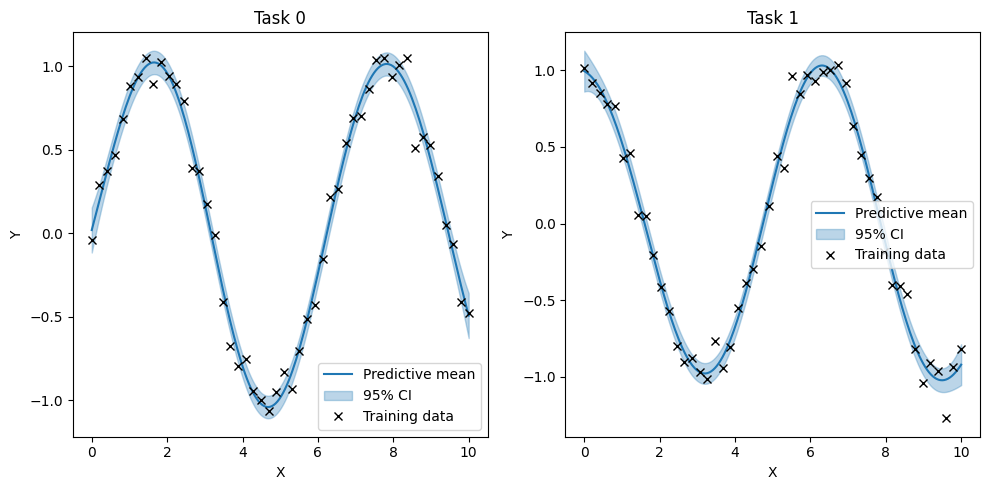

In [34]:
import matplotlib.pyplot as plt

# Number of tasks
num_tasks = 2

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

plt.figure(figsize=(10, 5))

for task in range(num_tasks):
    # Select training data for this task
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx][:, 0]
    Y_train_task = Y_multi[idx][:, 0]

    # Create test input for this task (attach task index)
    task_col = np.full_like(X_test, task)
    X_test_task = np.hstack([X_test, task_col])

    # Predict
    mean, var = model.predict_f(X_test_task)
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)

    # Plot
    plt.subplot(1, num_tasks, task + 1)
    plt.title(f"Task {task}")
    plt.plot(X_test, mean, 'C0', label='Predictive mean')
    plt.fill_between(X_test[:, 0], lower[:, 0], upper[:, 0], color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

plt.tight_layout()
plt.show()


# Test